In [10]:
import ee
ee.Authenticate()
ee.Initialize()

In [11]:
import os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [12]:
datapath='C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Toolbox-master/LEAF-Landsat-Validation-paper/data/LS_SL2PV0_spatialbuffer0/'

### Browse input data

In [13]:
# parameters for validation figures and  statistics 
sampleLAIFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_LAI_0-1000_2000_3000.pkl')
samplefCOVERFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_fCOVER_0-1000_2000_3000.pkl')
samplefAPARFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_fAPAR_0-1000_2000_3000.pkl')

In [14]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in os.path.split(os.path.abspath(siteDF.name))[-1]:   
        siteDF['network'] = 'GBOV'
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std' }  

    elif 'NEON' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'NEON'
        newNames = {'SITE': 'Site', \
                    'PLOT_ID':'PlotID',\
                    'nlcd':'NLCD_class',\
                    'clumping_index_Miller_understoryest' : 'clumping_Miller_down' , \
                    'clumping_index_Miller_understoryerror': 'clumping_Miller_down_err' , \
                    'clumping_index_Miller_overstoryest': 'clumping_Miller_up', \
                    'clumping_index_Miller_overstoryerror': 'clumping_Miller_up_err', \
                    'clumping_index_Warren_understoryest': 'clumping_Warren_down', \
                    'clumping_index_Warren_understoryerror': 'clumping_Warren_down_err', \
                    'clumping_index_Warren_overstoryest': 'clumping_Warren_up', \
                    'clumping_index_Warren_overstoryerror': 'clumping_Warren_up_err' , \
                    'datetime': 'Date', \
                    'understory_flag': 'down_flag' , \
                    'FIPAR_understoryest': 'fAPAR_down', \
                    'FIPAR_understoryerror': 'fAPAR_down_err', \
                    'FIPAR_overstoryest': 'fAPAR_up', \
                    'FIPAR_overstoryerror':'fAPAR_up_err', \
                    'FCOVER_understoryest': 'fCOVER_down', \
                    'FCOVER_understoryerror':'fCOVER_down_err', \
                    'FCOVER_overstoryest':'fCOVER_up', \
                    'FCOVER_overstoryerror': 'fCOVER_up_err', \
                    
                    'true_LAI_Miller_understoryest':'PAI_Miller_down', \
                    'true_LAI_Miller_understoryerror':'PAI_Miller_down_err', \
                    'true_LAI_Miller_overstoryest':'PAI_Miller_up', \
                    'true_LAI_Miller_overstoryerror':'PAI_Miller_up_err', \
                    'true_LAI_Warren_understoryest':'PAI_Warren_down', \
                    'true_LAI_Warren_understoryerror':'PAI_Warren_down_err', \
                    'true_LAI_Warren_overstoryest':'PAI_Warren_up', \
                    'true_LAI_Warren_overstoryerror':'PAI_Warren_up_err', \
                    
                    'effective_LAI_Miller_understoryest':'PAIe_down', \
                    'effective_LAI_Miller_understoryerror':'PAIe_down_err', \
                    'effective_LAI_Miller_overstoryest':'PAIe_up', \
                    'effective_LAI_Miller_overstoryerror':'PAIe_up_err', \
                    'effective_LAI_Warren_understoryest':'PAIe_Warren_down', \
                    'effective_LAI_Warren_understoryerror':'PAIe_Warren_down_err', \
                    'effective_LAI_Warren_overstoryest':'PAIe_Warren_up', \
                    'effective_LAI_Warren_overstoryerror':'PAIe_Warren_up_err', \
                    'PLOT_ID':'PLOT_ID', \
                    'timeStart':'timeStart', \
                    'overstory_flag':'up_flag', \
                    'combined_flag':'combined_flag'}
                    
    return  siteDF.rename(columns = newNames)

In [15]:
def rename_nlcd_class (samplesDF) :
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'evergreenForest')           ,'NLCD_class'] = 'Evergreen Forest'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'deciduousForest')           ,'NLCD_class'] = 'Deciduou sForest' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'mixedForest')               ,'NLCD_class'] = 'Mixed Forest'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'cultivatedCrops')           ,'NLCD_class'] = 'Cultivated Crops'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'pastureHay')                ,'NLCD_class'] = 'Pasture Hay' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'dwarfScrub')                ,'NLCD_class'] = 'Dwarf Scrub'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'shrubScrub')                ,'NLCD_class'] = 'Shrub Scrub' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'woodyWetlands')             ,'NLCD_class'] = 'Woody Wetlands' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'emergentHerbaceousWetlands'),'NLCD_class'] = 'Emergent Herbaceous Wetlands'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'sedgeHerbaceous')           ,'NLCD_class'] = 'Sedge Herbaceous'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'grasslandHerbaceous')       ,'NLCD_class'] = 'Grassland Herbaceous'
    return (samplesDF)

In [16]:
def format_feature0(feat,variablename):
    D=dict()
    for key in feat.keys():
        cols=list(feat[key][0].keys())
        A=[feat[key][ii][cols[0]] for ii in range(len(feat[key]))]
        B=[feat[key][ii][cols[1]] for ii in range(len(feat[key]))]
        for ii in range(len(feat[key])):
            A[ii]['sample%s'%(variablename)]=B[ii]
        D.update({key:A}) 
    return D

In [17]:
def in_data_analysis(sampleFileName,variableName):
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)

    sampleDictionary=format_feature0(sampleDictionary,variableName)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    for key in sitesList:
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)
        siteDF=rename_nlcd_class(siteDF)

        numValid = []
        numSamples = []
        nSamp=[]
        meanSamp=[]
        stdSamp=[]
        for index,site in siteDF.iterrows():
            if not site['sample'+variableName].empty:
                siteQC = site['sample'+variableName]['QC'].values
                estimate= site['sample'+variableName]['estimate'+variableName].values
            else: 
                siteQC=[]
                (numest,est_m,est_std)=(0,np.nan,np.nan)
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
            nSamp.append(numest)
            meanSamp.append(np.nanmean(estimate))
            
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        nSampDF=pd.DataFrame(nSamp,columns=['nSamp'])
        meanSampDF=pd.DataFrame(meanSamp,columns=['SL2P_m'])
        
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF,nSampDF,meanSampDF,stdSampDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    samplesDF = samplesDF.reset_index(drop=True)
    return  samplesDF   

In [18]:
df=in_data_analysis(sampleLAIFileName,'LAI')
df['PAI_Warren_total'] = df['PAI_Warren_up'].add(df['PAI_Warren_down']) 
df['PAI_Miller_total'] = df['PAI_Miller_up'].add(df['PAI_Miller_down']) 
df=df[['NLCD_class','PAI_Warren_total','PAI_Miller_total','nSamp','SL2P_m','SL2P_std']]

In [22]:
df1=df
df1=df1[df1['SL2P_m']>0]
df1=df1[df1['PAI_Miller_total']>0]
# df1=df1[df1['PAI_Warren_total']>0]
df1.shape

(57, 6)

In [20]:
# plt.plot(df1.PAI_Miller_total,'.r')
# plt.plot(df1.PAI_Warren_total,'.b')
# plt.plot(df1.SL2P_m,'ok')
# #print(nlcd)

(0.0, 7.0)

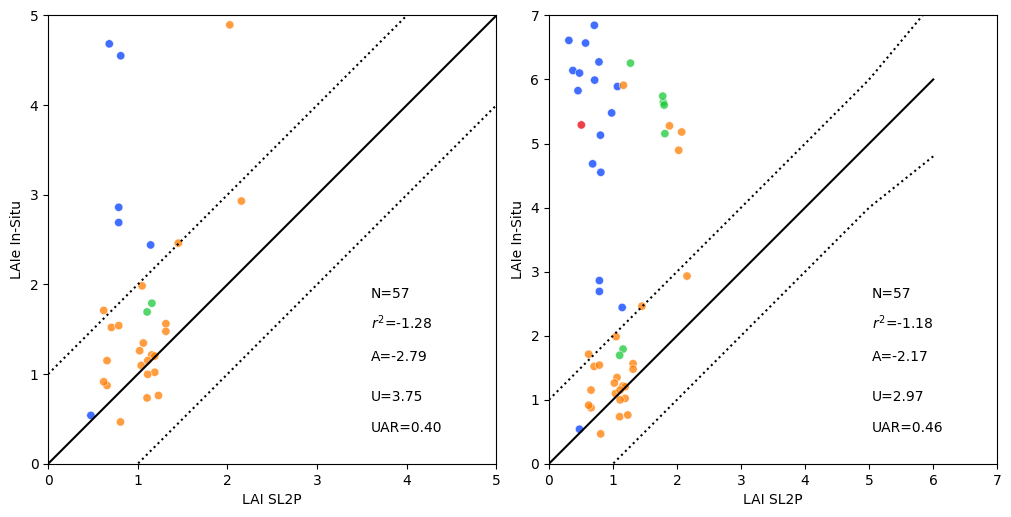

In [21]:
fig, ax = plt.subplots(1,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = df1

y = data['PAI_Miller_total']
x = data['SL2P_m']
sns.scatterplot(data=data, x='SL2P_m', y='PAI_Miller_total', hue='NLCD_class', sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0],legend=False)
ax[0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[0].plot([0,6],[0,6],color='black')
ax[0].set(adjustable='box',aspect='equal')
ax[0].set_ylabel('LAIe In-Situ')
ax[0].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['PAI_Warren_total']
x = data['SL2P_m']
sns.scatterplot(data=data, x='SL2P_m', y='PAI_Miller_total', hue='NLCD_class', sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[1],legend=False)
ax[1].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[1].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[1].plot([0,6],[0,6],color='black')
ax[1].set(adjustable='box',aspect='equal')
ax[1].set_ylabel('LAI In-Situ')
ax[1].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

ax[0].set_xlim([0,5])
ax[1].set_xlim([0,7])
ax[0].set_ylim([0,5])
ax[1].set_ylim([0,7])
